# Flow Matching tutorial: training ODE generative models like Diffusion models

## Introduction

**Flow Matching was introduced in three different ICLR 2023 papers and has drawn a lot of attention in the machine learning community recently. We would like to highlight all of them here: Flow Matching [(Lipman et al.)](https://arxiv.org/abs/2210.02747), Stochastic Interpolants [(Albergo et al.)](https://arxiv.org/abs/2209.15571) and Rectified Flow [(Liu et al.)](https://arxiv.org/abs/2209.03003).**

Flow Matching, a recently introduced generative model, leverages an ordinary differential equation (ODE) to mold a base density into the desired data distribution. In contrast, diffusion is based on a stochastic differential equation (SDE). This notebook illustrates the training of Flow Matching methods, highlighting key components. In this notebook, we present two Flow Matching models built upon the original formulation: Independent Conditional Flow Matching (I-CFM) and Optimal Transport Conditional Flow Matching (OT-CFM).

In our notation, $\alpha$ represents the noise distribution, typically a Gaussian, while $\beta$ denotes the distribution corresponding to real data.

Note from the authors: this is a beta tutorial! Do not hesitate to suggest improvements through the opened issue https://github.com/atong01/conditional-flow-matching/issues/88

## ODE: transforming a data distribution into another one

Let's delve into some foundational concepts.  We consider a smooth time-varying vector field $u : [0, 1] \times \mathbb{R}^d \to \mathbb{R}^d$ that defines an ordinary differential equation:
$$
dx = u_t(x)\,dt.
$$

We denote by $\phi_t(x)$ the solution of the ODE with initial condition $\phi_0(x)=x$. In essence, $\phi_t(x)$ represents the trajectory of a point $x$ transported along the vector field $u$ from time $0$ to $t$. 

Assuming the knowledge of the distributions $p_0$ and $p_1$, a transformative process between them can be initiated. The integration map $\phi_t$ induces a pushforward measure $p_t:=[\phi_t]_\#(p_0)$ between $p_0$ and $p_1$. This measure characterizes the density of points $x\sim p_0$ transported by $u$ from time $0$ to time $t$. The time-varying density $p_t$, viewed as a function $p:[0,1]\times\mathbb{R}^d\to\mathbb{R}$, is characterized by the initial conditions $\phi_0(x)=x$ and the well-known $\textbf{continuity equation}$:
\begin{equation}
\frac{\partial p}{\partial t}=-\nabla\cdot(p_t u_t)
\end{equation}

## Regressing the vector field: an intractable loss

Suppose we have knowledge of the probability path $p_t(x)$ and the associated vector field $u_t(x)$ that generates it, with the added convenience that $p_t(x)$ is readily samplable.

If $v_\theta(\cdot,\cdot):[0,1]\times\mathbb{R}^d\to\mathbb{R}^d$ is a time-dependent vector field parametrized as a neural network (with weights $\theta$), we aim to regress $v_\theta$ to $u$ using the $\textbf{flow matching (FM)}$ objective:

$$
\mathcal{L}_{\text{FM}}(\theta) := \mathbb{E}_{t\sim [0,1],x\sim p_t(x)} \| v_\theta(t, x) - u_t(x) \|^2.
$$

This objective allows us to align $v_\theta$ with $u$ by minimizing the expected squared norm difference across various time points $t$ and sampled points $x$ from $p_t(x)$. Then we can generate data by using $v_\theta$ in place of $u$ in the above ODE. However, this objective becomes intractable for general source and target distributions as $p_t(x)$ and $u_t$ are unknown general functions.

## Conditional Flow Matching

The primary limitation of the above approach is that it is untractable as we do not know $u_t$ and $p_t$. To render the objective feasible, we opt for a more manageable strategy by specifying the form of the probability path and vector field.

Here, we assume that the probability path $p_t(x)$ takes the form of a mixture involving **conditional probability paths $p_t(x|z)$**, where $z$ serves as a conditioning variable:

\begin{equation}\label{eq:ppath}
p_t(x) := \int p_t(x | z) q(z)\, dz.
\end{equation}
$q(z)$ represents a distribution over the conditioning variable. Furthermore, we want $p_1(x | z)$ to be a distribution concentrated around $z$.  A natural design choise for the conditional probability path $p_t(x|z)$ is to adopt Gaussian distributions, expressed as $p_t(x | z) = \mathcal{N}(\mu_t(z), \sigma_t^2)$. In our paper, we choose to condition over a tuple of source and target samples $z = (x_0, x_1) \sim \alpha \otimes \beta$. We define $\mu_t$ as the linear interpolation between $x_0$ and $x_1$ (with respect to time, *i.e.,* $\mu_t(x_0, x_1) = t x_1 + (1 - t) x_0$), and set the standard deviation $\sigma_t = \sigma>0$ as a constant float. The motivation behind this specific $\mu_t$ lies in the optimal transport theory that we will detail later. It's worth noting that alternate selections are possible as highlithed in (Lipman et al, 2023).

Unfortunately, direct sampling from the unconditional probability path $p_t(x)$ is hindered by the integral in its formulation. Instead, we will sample from the conditional probability path $p_t(x|z)$ and show later that we can build a conditional Flow Matching loss which shares a lot of benefits with its unconditional counter part.

In [1]:
def sample_conditional_pt(x0, x1, t, sigma):
    """
    Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

## Building an admissible vector field

We proceed with the assumption that the conditional probability paths $p_t(x|z)$, used to define the unconditional probability path, are generated by some conditional vector field $u_t(x|z)$. 

The next challenge is to define an unconditional vector field $u_t(x)$ that, when paired with $p_t(x)$, satisfies the continuity equation.

Drawing from an adapted theorem based on [(Lipman et al., Theorem 1)](https://arxiv.org/abs/2210.02747), we can establish the existence of such a vector field, as demonstrated in [(Tong et al., Theorem 3.1)](https://arxiv.org/abs/2302.00482). Inheritantly influenced by the structure of $p_t$, $u_t$ takes the form of a mixture involving the conditional vector field $u_t(x | z)$. Formally, it will be defined by:

\begin{equation}\label{eq:mvec}
u_t(x) := \mathbb{E}_{q(z)} \frac{u_t(x | z) p_t(x | z)}{p_t(x)}.
\end{equation}

This formulation ensures that $u_t$ aligns with the theoretical requirements to satisfy the continuity equation when associated with $p_t(x)$. Once more, the complexity introduced by the integral renders the above $u_t(x)$ impractical for direct use. Instead, we rely on use its conditional counterpart $u_t(x|z)$. 

In the specefic case where the conditional probability path $p_t(x|z) = \mathcal{N}(\mu_t(z), \sigma_t^2)$ takes the form of a Gaussian, the conditional vector field $u_t(x|z)$ possesses a unique closed-form expression:

\begin{equation}
u_t(x|x_0, x_1) = \frac{\sigma_t'}{\sigma_t} (x - \mu_t) + \mu_t',
\end{equation}

As $\mu_t(x_0, x_1) = t x_1 + (1-t) x_0$ and $\sigma_t = \sigma>0$, the conditional vector field $u_t(x∣z)$ simplifies further:

\begin{equation}
u_t(x|x_0, x_1) = x_1 - x_0.
\end{equation}

In [2]:
def compute_conditional_vector_field(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0

As explained earlier,  the computation of the unconditional vector field $u_t(x)$ and probability path $p_t(x)$ are intractable. Nevertheless, we can easily sample from the conditional probability path $p_t(x|z)$, given its Gaussian nature, and compute the conditional vector field $u_t(x|z)$ with the available closed-form expression.  Consequently, instead of regressing against the unconditional vector field, we opt to regress our network $v_\theta$ against the $\textit{conditional vector field}$ $u_t(x|z)$. The Conditional Flow Matching loss is thus defined as:

$$
\mathcal{L}_{\text{CFM}}(\theta) := \mathbb{E}_{t, q(z), p_t(x | z)} \|v_\theta(t, x) - u_t(x | z)\|^2.
$$

Remarkably, the expectation in this loss reflects the definition of $u_t(x)$. Furthermore, this loss is equal to the unconditional Flow Matching loss, up to a constant that is independent of $\theta$ (Theorem 2, [(Lipman et al.)](https://arxiv.org/abs/2210.02747), Theorem 3.2 [(Tong et al.)](https://arxiv.org/abs/2302.00482)).

It's important to note that the constructed marginal probability path $p_t(x)$ and the derived vector field $u_t(x)$ do not encompass all probability paths and vector fields that satisfy the continuity equation as defined in the ODE section.

## Choosing $q$

Another crucial element to consider is the choice of the latent distribution $q(z)$. Presently, we opt for a straightforward approach by considering a uniform distribution over a tuple of noise and real data, i.e., $q(z) = q(x_0,x_1) = q(x_0) q(x_1)$. We will see later different choices for $q$.

In [3]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

In [5]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [17]:
x0 = sample_8gaussians(batch_size).to(device)
x1 = sample_moons(batch_size).to(device)
t = torch.rand(x0.shape[0], device=device).type_as(x0)
t

tensor([0.5868, 0.5222, 0.6758, 0.0920, 0.2367, 0.4137, 0.6999, 0.3651, 0.7314,
        0.5464, 0.4396, 0.5089, 0.8230, 0.6940, 0.3176, 0.8669, 0.1175, 0.7080,
        0.6506, 0.1876, 0.6835, 0.9216, 0.0541, 0.4762, 0.4601, 0.5810, 0.4847,
        0.4468, 0.7769, 0.9224, 0.9719, 0.1871, 0.8674, 0.8886, 0.4241, 0.4485,
        0.9426, 0.9323, 0.4420, 0.4718, 0.4924, 0.3518, 0.2154, 0.9868, 0.3152,
        0.1776, 0.8016, 0.7556, 0.4679, 0.5150, 0.5857, 0.1453, 0.8195, 0.5103,
        0.3255, 0.9496, 0.3476, 0.1185, 0.0597, 0.1093, 0.3725, 0.1429, 0.1061,
        0.5973, 0.0552, 0.4763, 0.8324, 0.7101, 0.5637, 0.2707, 0.4745, 0.4255,
        0.6762, 0.9966, 0.5151, 0.5572, 0.9878, 0.8307, 0.4046, 0.3796, 0.8201,
        0.2225, 0.7095, 0.5543, 0.6298, 0.5775, 0.5352, 0.2980, 0.7585, 0.9277,
        0.7858, 0.5429, 0.4567, 0.2985, 0.5744, 0.1901, 0.0142, 0.0579, 0.5843,
        0.4514, 0.4207, 0.1713, 0.1157, 0.1775, 0.9806, 0.3333, 0.1706, 0.1007,
        0.0273, 0.9695, 0.3763, 0.9592, 

In [19]:
xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
xt

tensor([[ 1.1038e+00, -2.5576e+00],
        [ 2.9433e+00, -2.1726e+00],
        [-1.5500e-01, -2.8307e-01],
        [ 3.2523e+00,  3.3524e+00],
        [ 4.3358e-01, -4.0464e+00],
        [-1.2796e+00, -2.2153e+00],
        [-2.2663e-01, -6.2531e-01],
        [ 2.8794e+00, -1.8611e+00],
        [ 2.7688e+00,  6.0883e-01],
        [ 3.0085e+00, -6.3962e-02],
        [-1.2845e+00, -2.3805e+00],
        [-1.2710e+00, -1.1327e-01],
        [ 2.6746e+00,  2.5672e-01],
        [ 2.5069e+00,  1.4860e+00],
        [ 2.7311e+00,  2.9462e+00],
        [ 2.5411e+00,  3.5704e-01],
        [ 4.2955e-02,  5.2371e+00],
        [ 2.5278e+00, -7.6060e-01],
        [-4.5038e-01,  5.0737e-01],
        [ 4.7120e+00, -2.5852e-02],
        [ 5.4940e-01, -6.0413e-01],
        [ 1.4167e+00,  3.6447e-01],
        [-3.0033e+00,  3.9456e+00],
        [ 5.3654e-01,  2.6339e+00],
        [ 6.1937e-01, -1.9577e+00],
        [ 4.2249e-01,  2.6641e+00],
        [ 1.9877e+00,  2.0731e+00],
        [ 8.5204e-01, -2.585

In [21]:
t[:, None]

tensor([[0.5868],
        [0.5222],
        [0.6758],
        [0.0920],
        [0.2367],
        [0.4137],
        [0.6999],
        [0.3651],
        [0.7314],
        [0.5464],
        [0.4396],
        [0.5089],
        [0.8230],
        [0.6940],
        [0.3176],
        [0.8669],
        [0.1175],
        [0.7080],
        [0.6506],
        [0.1876],
        [0.6835],
        [0.9216],
        [0.0541],
        [0.4762],
        [0.4601],
        [0.5810],
        [0.4847],
        [0.4468],
        [0.7769],
        [0.9224],
        [0.9719],
        [0.1871],
        [0.8674],
        [0.8886],
        [0.4241],
        [0.4485],
        [0.9426],
        [0.9323],
        [0.4420],
        [0.4718],
        [0.4924],
        [0.3518],
        [0.2154],
        [0.9868],
        [0.3152],
        [0.1776],
        [0.8016],
        [0.7556],
        [0.4679],
        [0.5150],
        [0.5857],
        [0.1453],
        [0.8195],
        [0.5103],
        [0.3255],
        [0

In [25]:
t.reshape(-1, *([1] * (x0.dim() - 1)))

tensor([[0.5868],
        [0.5222],
        [0.6758],
        [0.0920],
        [0.2367],
        [0.4137],
        [0.6999],
        [0.3651],
        [0.7314],
        [0.5464],
        [0.4396],
        [0.5089],
        [0.8230],
        [0.6940],
        [0.3176],
        [0.8669],
        [0.1175],
        [0.7080],
        [0.6506],
        [0.1876],
        [0.6835],
        [0.9216],
        [0.0541],
        [0.4762],
        [0.4601],
        [0.5810],
        [0.4847],
        [0.4468],
        [0.7769],
        [0.9224],
        [0.9719],
        [0.1871],
        [0.8674],
        [0.8886],
        [0.4241],
        [0.4485],
        [0.9426],
        [0.9323],
        [0.4420],
        [0.4718],
        [0.4924],
        [0.3518],
        [0.2154],
        [0.9868],
        [0.3152],
        [0.1776],
        [0.8016],
        [0.7556],
        [0.4679],
        [0.5150],
        [0.5857],
        [0.1453],
        [0.8195],
        [0.5103],
        [0.3255],
        [0

In [20]:
torch.cat([xt, t[:, None]], dim=-1)

tensor([[ 1.1038e+00, -2.5576e+00,  5.8677e-01],
        [ 2.9433e+00, -2.1726e+00,  5.2221e-01],
        [-1.5500e-01, -2.8307e-01,  6.7584e-01],
        [ 3.2523e+00,  3.3524e+00,  9.1960e-02],
        [ 4.3358e-01, -4.0464e+00,  2.3667e-01],
        [-1.2796e+00, -2.2153e+00,  4.1375e-01],
        [-2.2663e-01, -6.2531e-01,  6.9987e-01],
        [ 2.8794e+00, -1.8611e+00,  3.6515e-01],
        [ 2.7688e+00,  6.0883e-01,  7.3136e-01],
        [ 3.0085e+00, -6.3962e-02,  5.4639e-01],
        [-1.2845e+00, -2.3805e+00,  4.3964e-01],
        [-1.2710e+00, -1.1327e-01,  5.0892e-01],
        [ 2.6746e+00,  2.5672e-01,  8.2303e-01],
        [ 2.5069e+00,  1.4860e+00,  6.9395e-01],
        [ 2.7311e+00,  2.9462e+00,  3.1765e-01],
        [ 2.5411e+00,  3.5704e-01,  8.6690e-01],
        [ 4.2955e-02,  5.2371e+00,  1.1751e-01],
        [ 2.5278e+00, -7.6060e-01,  7.0805e-01],
        [-4.5038e-01,  5.0737e-01,  6.5056e-01],
        [ 4.7120e+00, -2.5852e-02,  1.8759e-01],
        [ 5.4940e-01

In [65]:
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model.parameters())

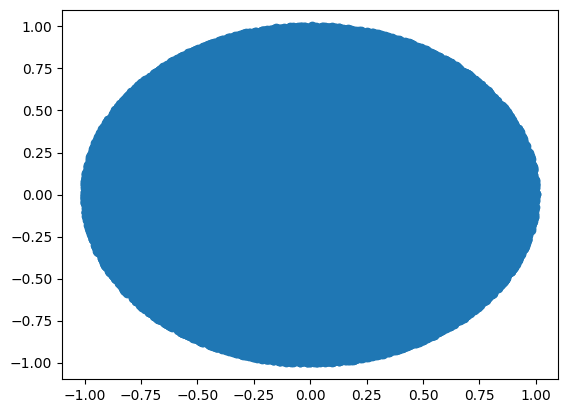

In [127]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2), device='cpu'):
    data = (torch.rand((max_num,2), device=device)-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale, device=device)
    return data


batch_size= 256

target_set = generate_ellipse(max_num=100000, scale=(1,1.), device=device)
target_set = target_set[:target_set.shape[0]//batch_size*batch_size]
plt.scatter(np.array(target_set.cpu())[:,0], np.array(target_set.cpu())[:,1])
target_loader = torch.utils.data.DataLoader(target_set, batch_size=batch_size, shuffle=True)

source_set = torch.randn(10000, 2, device=device)


In [73]:
target_set = target_set[:target_set.shape[0]//batch_size*batch_size]

7680

In [128]:
%%time

sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()

for k in range(100):
    for i, x1 in enumerate(target_loader):
        optimizer.zero_grad()
        
        x0 = torch.randn(batch_size, 2, device=device)
        
        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)
        
        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)
    
        loss.backward()
        optimizer.step()
        
# for k in range(20000):
#     optimizer.zero_grad()

#     x0 = torch.randn(batch_size, 2, device=device)
#     x1 = sample_moons(batch_size).to(device)

#     t = torch.rand(x0.shape[0], device=device).type_as(x0)
#     xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
#     ut = compute_conditional_vector_field(x0, x1)

#     vt = model(torch.cat([xt, t[:, None]], dim=-1))
#     loss = torch.mean((vt - ut) ** 2)

#     loss.backward()
#     optimizer.step()

#     if (k + 1) % 5000 == 0:
#         end = time.time()
#         print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
#         start = end
#         node = NeuralODE(
#             torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
#         )
#         with torch.no_grad():
#             traj = node.trajectory(
#                 sample_8gaussians(1024).to(device),
#                 t_span=torch.linspace(0, 1, 100).to(device),
#             )
#             plot_trajectories(traj.cpu().numpy())

CPU times: total: 3min 18s
Wall time: 1min 10s


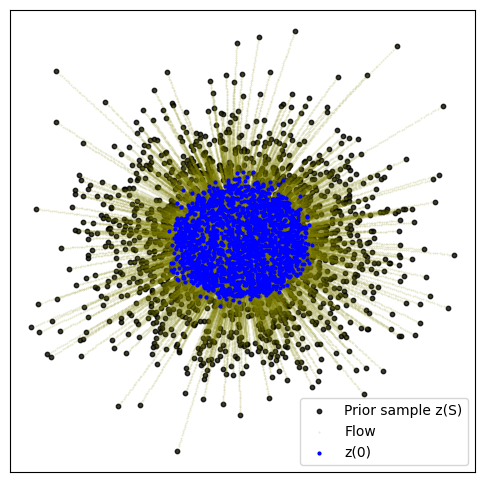

CPU times: total: 3.8 s
Wall time: 2.72 s


In [129]:
%%time

node = NeuralODE(
    torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(10024, 2, device=device),
        t_span=torch.linspace(0, 1, 100).to(device),
    )
    plot_trajectories(traj.cpu().numpy())

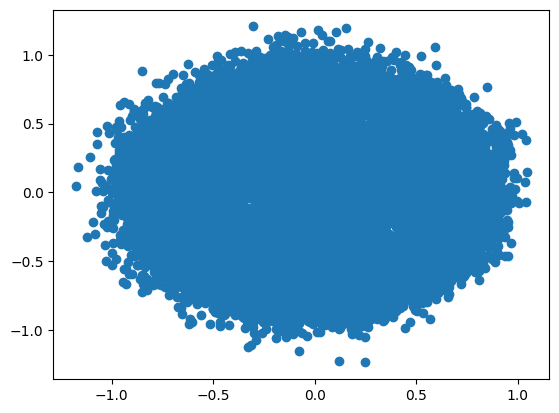

In [130]:
transformed = traj[-1].detach().cpu().numpy()
plt.scatter(transformed[:,0], transformed[:,1])

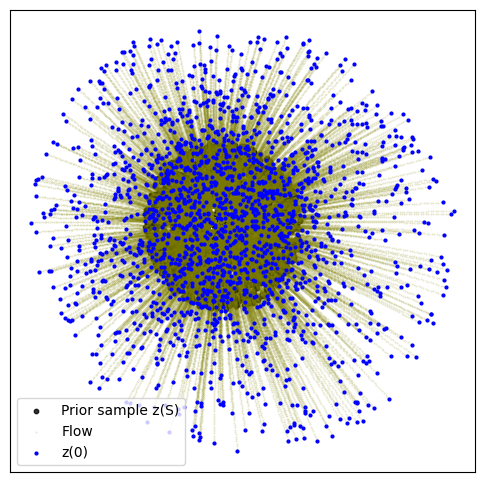

In [131]:
uniform = generate_ellipse(max_num=10000, scale=(1,1.), device=device)

with torch.no_grad():
    traj = node.trajectory(
        uniform,
        t_span=torch.linspace(1, 0, 100).to(device),
    )
    plot_trajectories(traj.cpu().numpy())

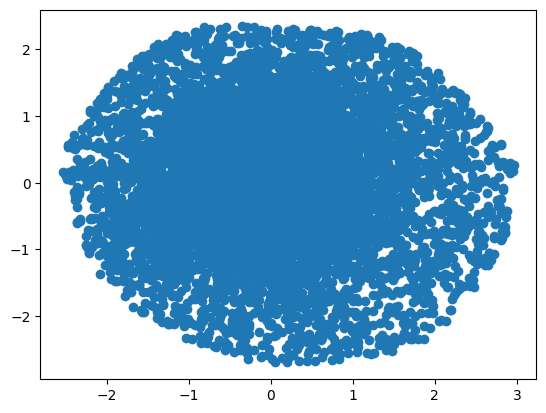

In [132]:
transformed = traj[-1].detach().cpu().numpy()
plt.scatter(transformed[:,0], transformed[:,1])

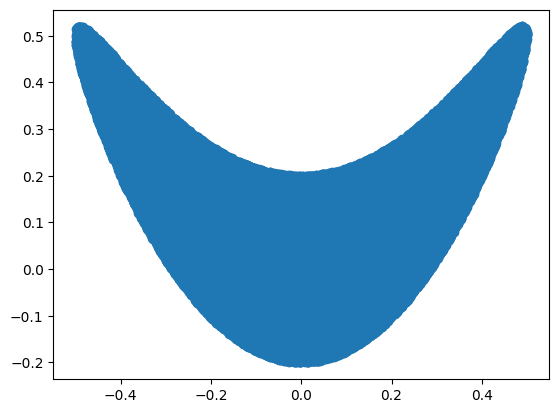

In [140]:
def generate_banana(n=100000, device=device):
    train_loader = generate_ellipse(n, device=device)
    train_loader[:, 1] = train_loader[:,1] + 2*train_loader[:,0]**2
    return train_loader

batch_size= 256

target_set = generate_banana(n=100000, device=device)
target_set = target_set[:target_set.shape[0]//batch_size*batch_size]
plt.scatter(np.array(target_set.cpu())[:,0], np.array(target_set.cpu())[:,1])
target_loader = torch.utils.data.DataLoader(target_set, batch_size=batch_size, shuffle=True)


In [117]:
%%time

sigma = 0.1
dim = 2
batch_size = 256
model_banana = MLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model_banana.parameters())

start = time.time()

for k in range(100):
    for i, x1 in enumerate(target_loader):
        optimizer.zero_grad()
        
        x0 = torch.randn(batch_size, 2, device=device)
        
        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)
        
        vt = model_banana(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)
    
        loss.backward()
        optimizer.step()

CPU times: total: 3min 15s
Wall time: 1min 10s


In [141]:
%%time

for k in range(100):
    for i, x1 in enumerate(target_loader):
        optimizer.zero_grad()
        
        x0 = torch.randn(batch_size, 2, device=device)
        
        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)
        
        vt = model_banana(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)
    
        loss.backward()
        optimizer.step()

CPU times: total: 3min 11s
Wall time: 1min 4s


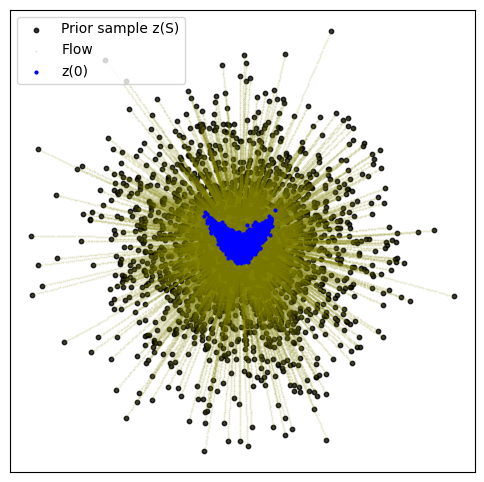

CPU times: total: 6.64 s
Wall time: 5.23 s


In [142]:
%%time

node = NeuralODE(
    torch_wrapper(model_banana), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(10024, 2, device=device),
        t_span=torch.linspace(0, 1, 100).to(device),
    )
    plot_trajectories(traj.cpu().numpy())

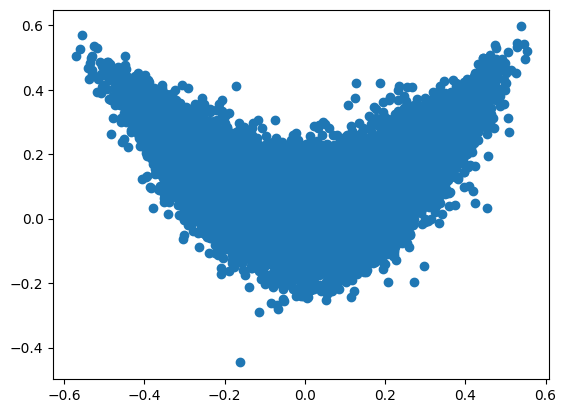

In [143]:
transformed = traj[-1].detach().cpu().numpy()
plt.scatter(transformed[:,0], transformed[:,1])

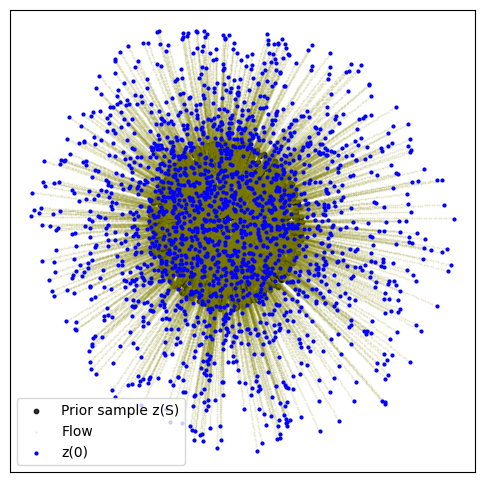

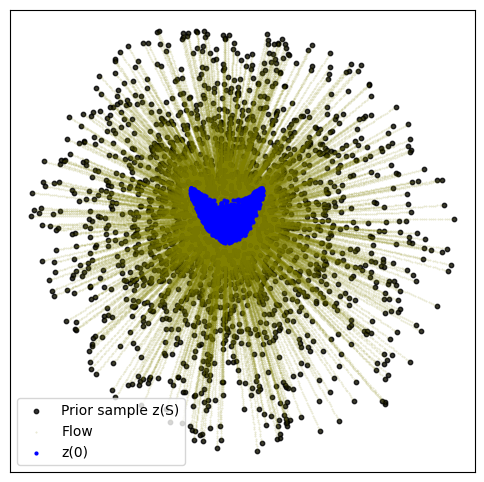

In [144]:
uniform = generate_ellipse(max_num=10000, scale=(1,1.), device=device)

node = NeuralODE(
    torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)

node_banana = NeuralODE(
    torch_wrapper(model_banana), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)

with torch.no_grad():
    traj1 = node.trajectory(
        uniform,
        t_span=torch.linspace(1, 0, 100).to(device),
    )
    plot_trajectories(traj1.cpu().numpy())

with torch.no_grad():
    traj2 = node_banana.trajectory(
        traj1[-1],
        t_span=torch.linspace(0, 1, 100).to(device),
    )
    plot_trajectories(traj2.cpu().numpy())



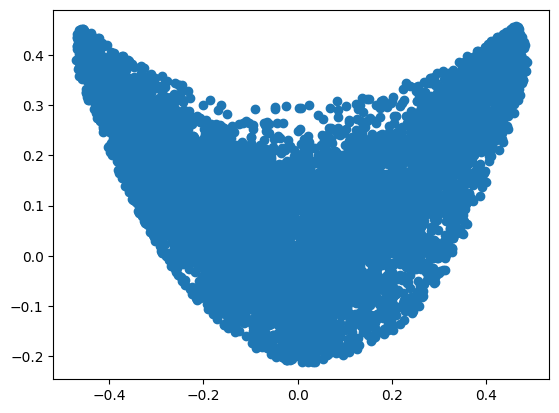

In [145]:
transformed = traj2[-1].detach().cpu().numpy()
plt.scatter(transformed[:,0], transformed[:,1])

In [ ]:
target_set = generate_banana(n=100000, device=device)
target_set = generate_ellipse(max_num=100000, scale=(1,1.), device=device)

In [148]:
%%time

sigma = 0.1
dim = 2
batch_size = 256
model_direct_banana = MLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model_direct_banana.parameters())

start = time.time()

for k in range(10000):
    optimizer.zero_grad()
    
    x0 = generate_ellipse(max_num=1000, scale=(1,1.), device=device)[:batch_size]
    x1 = generate_banana(n=1000, device=device)[:batch_size]
    
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)
    
    vt = model_direct_banana(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

CPU times: total: 24.4 s
Wall time: 24.5 s


In [166]:
for k in range(10000):
    optimizer.zero_grad()
    
    x0 = generate_ellipse(max_num=1000, scale=(1,1.), device=device)[:batch_size]
    x1 = generate_banana(n=1000, device=device)[:batch_size]
    
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)
    
    vt = model_direct_banana(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

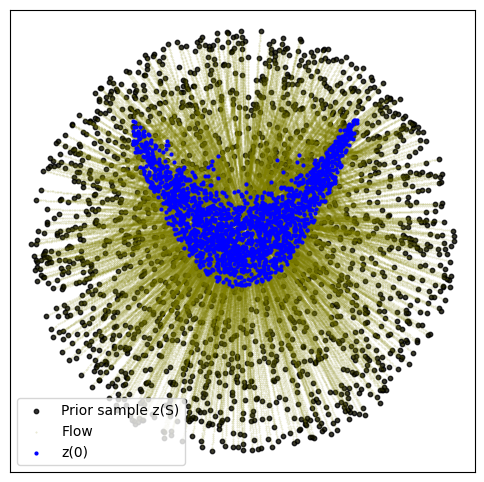

CPU times: total: 5.44 s
Wall time: 5.44 s


In [207]:
%%time

node_direct = NeuralODE(
    torch_wrapper(model_direct_banana), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
with torch.no_grad():
    traj = node_direct.trajectory(
        generate_ellipse(max_num=10000, scale=(1,1.), device=device),
        t_span=torch.linspace(0, 1, 100).to(device),
    )
    plot_trajectories(traj.cpu().numpy())

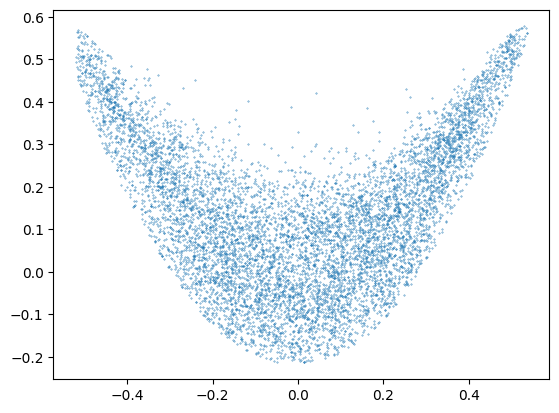

In [208]:
transformed = traj[-1].detach().cpu().numpy()
plt.scatter(transformed[:,0], transformed[:,1],s=0.1)

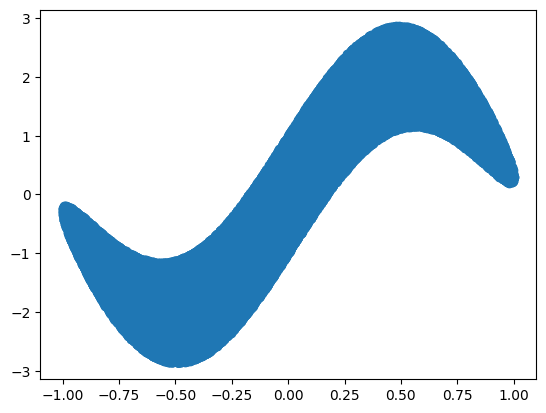

In [180]:
def generate_wave(n=100000, device='cpu'):
    train_loader = generate_ellipse(n, (1,1), device)
    train_loader[:, 1] = train_loader[:,1] + 2*torch.sin(3*train_loader[:,0])
    return train_loader
training_set = generate_wave(n=100000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

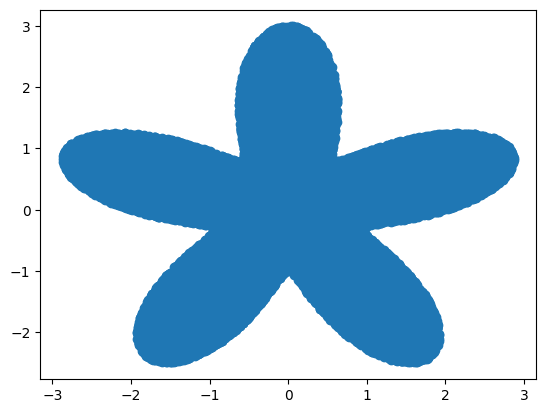

In [181]:
def generate_star(max_num = 10000, n_edges = 5, device='cpu'):
    data = generate_ellipse(max_num, scale=(3,3), device=device)
    angles = torch.arctan2(data[:,1],data[:,0])
    max_amplitude = torch.sin(n_edges*angles)+2
    amplitude = torch.sum(data**2,axis=1)**0.5
    data = data[amplitude <= max_amplitude]
    return data

training_set = generate_star(max_num=100000, n_edges=5, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

In [178]:
%%time

sigma = 0.1
dim = 2
batch_size = 1024
model_direct_wave = MLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model_direct_wave.parameters())

start = time.time()

for k in range(10000):
    optimizer.zero_grad()
    
    x0 = generate_ellipse(max_num=2000, scale=(1,1.), device=device)[:batch_size]
    x1 = generate_wave(n=2000, device=device)[:batch_size]

    t = torch.rand(x0.shape[0], device=device).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)
    
    vt = model_direct_wave(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

CPU times: total: 24.6 s
Wall time: 25.6 s


In [227]:
for k in range(200000):
    optimizer.zero_grad()
    
    x0 = generate_ellipse(max_num=2000, scale=(1,1.), device=device)[:batch_size]
    x1 = generate_wave(n=2000, device=device)[:batch_size]
    
    t = torch.rand(x0.shape[0], device=device).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)
    
    vt = model_direct_wave(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

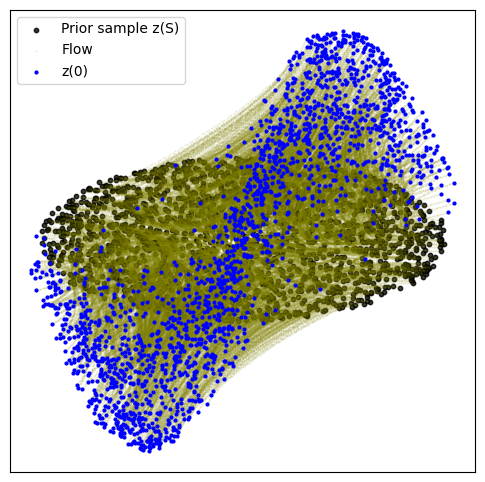

CPU times: total: 2.02 s
Wall time: 2.01 s


In [228]:
%%time

node_direct_wave = NeuralODE(
    torch_wrapper(model_direct_wave), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
with torch.no_grad():
    traj = node_direct_wave.trajectory(
        generate_ellipse(max_num=10000, scale=(1,1.), device=device),
        t_span=torch.linspace(0, 1, 100).to(device),
    )
    plot_trajectories(traj.cpu().numpy())

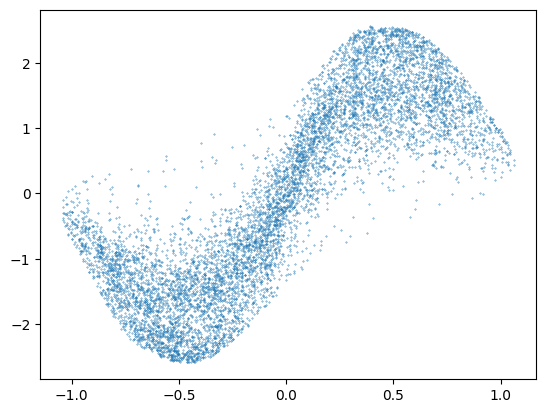

In [229]:
transformed = traj[-1].detach().cpu().numpy()
plt.scatter(transformed[:,0], transformed[:,1], s=0.1)

In [189]:
%%time

sigma = 0.1
dim = 2
batch_size = 1024
model_direct_star = MLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model_direct_star.parameters())

start = time.time()

for k in range(10000):
    optimizer.zero_grad()
    
    x0 = generate_ellipse(max_num=2000, scale=(1,1.), device=device)[:batch_size]
    x1 = generate_star(max_num = 3000, n_edges = 5, device=device)[:batch_size]

    t = torch.rand(x0.shape[0], device=device).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)
    
    vt = model_direct_star(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

CPU times: total: 26.4 s
Wall time: 26.6 s


In [248]:
for k in range(200000):
    optimizer.zero_grad()
    
    x0 = generate_ellipse(max_num=2000, scale=(1,1.), device=device)[:batch_size]
    x1 = generate_star(max_num = 3000, n_edges = 5, device=device)[:batch_size]

    t = torch.rand(x0.shape[0], device=device).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)
    
    vt = model_direct_star(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

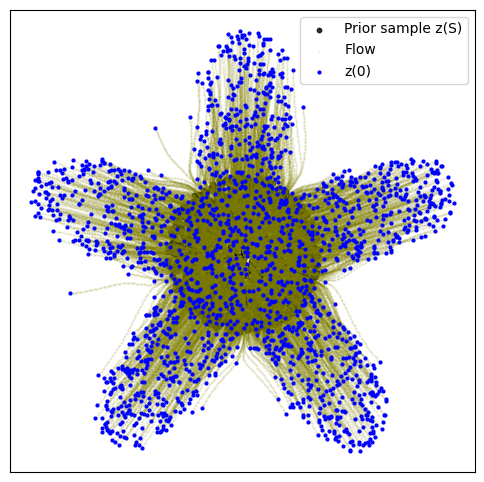

CPU times: total: 1.52 s
Wall time: 1.53 s


In [246]:
%%time

node_direct_star = NeuralODE(
    torch_wrapper(model_direct_star), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
with torch.no_grad():
    traj = node_direct_star.trajectory(
        generate_ellipse(max_num=10000, scale=(1,1.), device=device),
        t_span=torch.linspace(0, 1, 100).to(device),
    )
    plot_trajectories(traj.cpu().numpy())

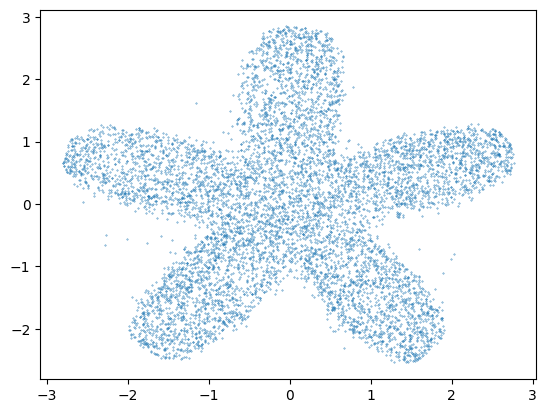

In [247]:
transformed = traj[-1].detach().cpu().numpy()
plt.scatter(transformed[:,0], transformed[:,1],s =0.1)

In [254]:
((10/np.pi)**0.5 * 2 * np.pi / 20)**2 * 20

6.283185307179586

In [255]:
2*np.pi

6.283185307179586

5000: loss 8.587 time 36.41


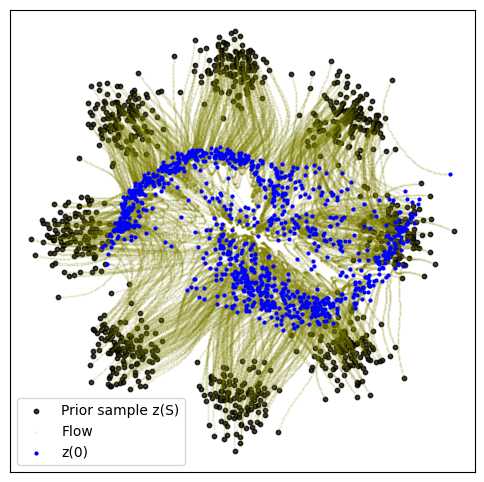

10000: loss 9.505 time 39.77


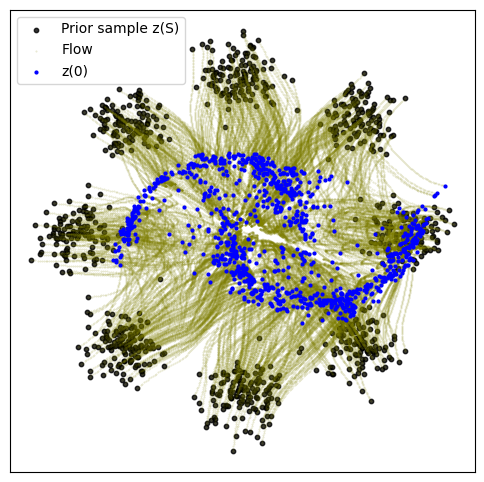

15000: loss 8.100 time 36.92


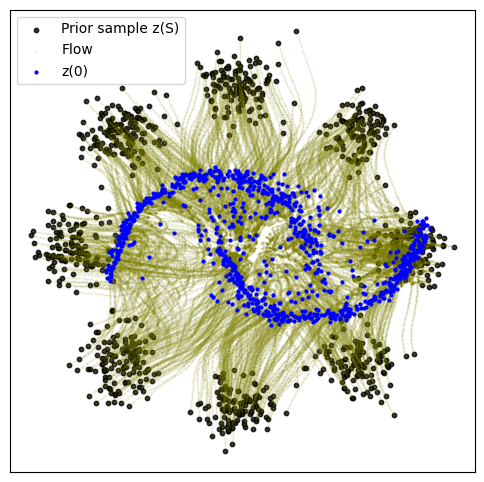

20000: loss 7.711 time 36.50


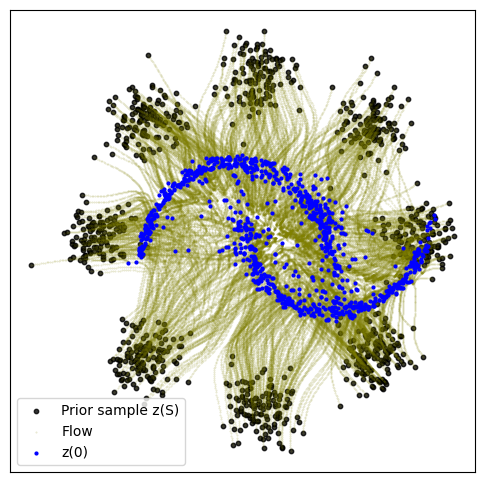

CPU times: total: 16min 51s
Wall time: 2min 32s


In [48]:
%%time

sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size).to(device)
    x1 = sample_moons(batch_size).to(device)

    t = torch.rand(x0.shape[0], device=device).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024).to(device),
                t_span=torch.linspace(0, 1, 100).to(device),
            )
            plot_trajectories(traj.cpu().numpy())

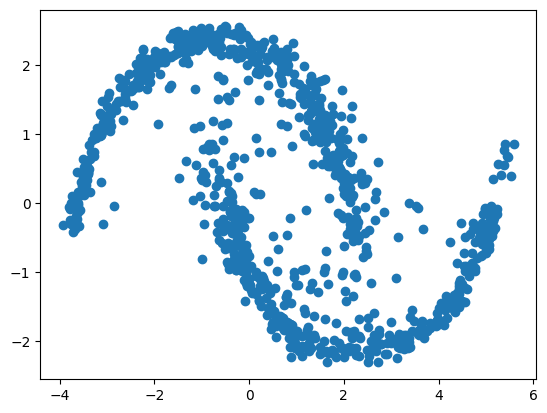

In [51]:
# Gaussian Result

X_train = sample_8gaussians(1024).to(device)
t_span=torch.linspace(0, 1, 100).to(device)
t_eval, trajectory = node(X_train, t_span)
transformed = trajectory[-1].detach().cpu().numpy()
plt.scatter(transformed[:,0], transformed[:,1])

20000: loss 7.711 time 27.04


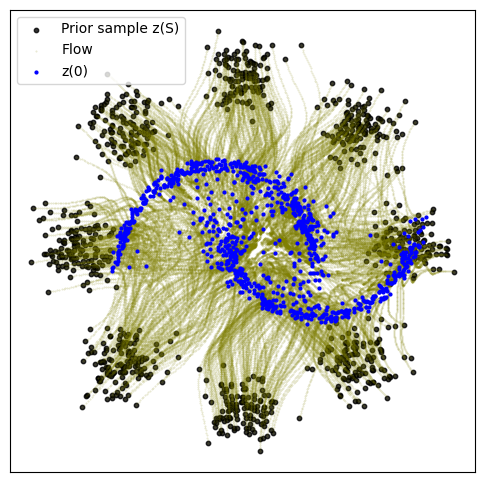

In [50]:
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024).to(device),
                t_span=torch.linspace(0, 1, 100).to(device),
            )
            plot_trajectories(traj.cpu().numpy())

In [54]:
np.array([160,51,58])*0.2

array([32. , 10.2, 11.6])

In [ ]:
# OT result

In [44]:
X_train = sample_8gaussians(1024).to(device)
t_span=torch.linspace(0, 1, 100).to(device)

In [45]:
t_eval, trajectory = node(X_train, t_span)

In [46]:
transformed = trajectory[-1].detach().cpu().numpy()

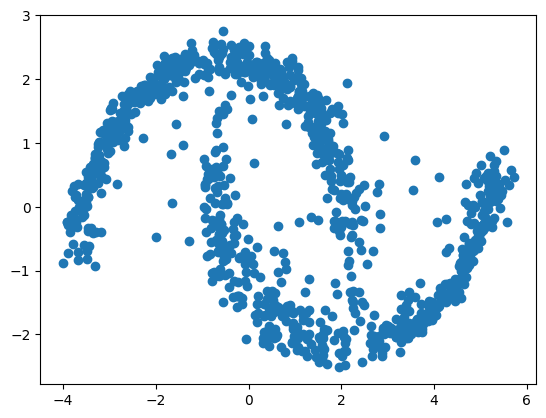

In [47]:
plt.scatter(transformed[:,0], transformed[:,1])

20000: loss 0.247 time 4978.61


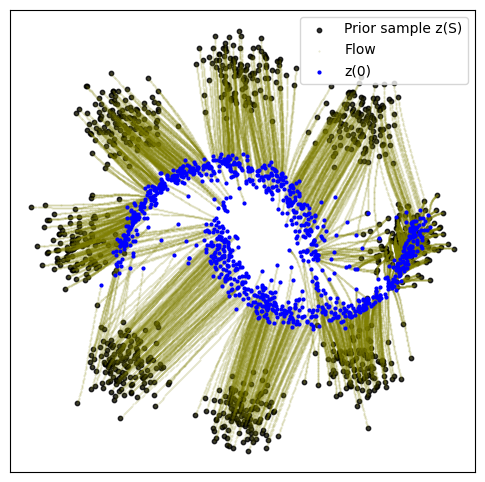

In [35]:
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024).to(device),
                t_span=torch.linspace(0, 1, 100).to(device),
            )
            plot_trajectories(traj.cpu().numpy())

As we can see above, the proposed method works really well to generate samples. However, the paths are rather curved. These paths are not efficient and lead to a longer inference than straighter paths would lead to. To get straighter paths, we can choose a different distribution $q$.

# Optimal Transport

To get straighter paths, we can leverage the optimal transport (OT) theory. Indeed, as discussed in [(Peyré et al., chapter 7)](https://arxiv.org/abs/1803.00567), the OT problem can be reformulated as a minimal-path length problem. Thus, we want to leverage this property in order to produce straighter flows that would lead to a faster inference process.

The OT problem aims to minimize the displacement cost between two distributions. Formally, let $\alpha = \frac1n \sum_{i=1}^n \delta_{x_i}$ and $\beta = \frac1n \sum_{j=1}^n \delta_{z_j}$ represents the source and target distributions (i.e., they are sum of diracs). 

Optimal Transport is based on two key notions: $\textbf{Transport}$ and $\textbf{cost}$. Let's delve into the first concept.

To transport a distribution towards another, we examine their probabilistic representation. The distribution $\alpha$ and $\beta$ are sum of diracs with uniform weights. This implies that we can represent them as tuples of a position and a probability weight (i.e., $(x_i, \frac1n)_{i=1}^n$ and $(z_j, \frac1n)_{j=1}^n$)). To move $\alpha$ towards $\beta$, the task is to transport each individual sample mass $\frac1n$ from $\alpha$ to $\beta$ samples.

To formalize this concept, we introduce a transport matrix, denoted as $\Pi$. Each row of $\Pi$ corresponds to a source sample, and each column represents a target sample. Thus, an element $\Pi_{ij}$ element represents the quantity of mass transported from $x_i$ to $z_j$. 

To ensure that each individual $\alpha$ sample is transported to $\beta$ (and vice-versa), the transport plan $\Pi$ must satisfy the following constraints: $\sum_j \Pi_{ij} = a_i = \frac1n$ and $\sum_i \Pi_{ij} = b_j = \frac1n$. It means that each sample's mass $\frac1n$ has been moved to the other distribution. These constraints guarantee the conservation of mass during the transport process.

Having established how to transport distributions, let's delve into the concept of a $\textbf{displacement cost}$. 

In the context of optimal transport, which aims to minimize the distance cost from $\alpha$ to $\beta$, we need a notion of distance. That is why we evaluate the distance between the supports of the source and target distributions (*i.e.*, $(x_i)_{i=1}^n$ for $\alpha$ and $(z_j)_{j=1}^n$ for $\beta$). This involves introducing a ground cost matrix $C$, where $C_{ij} = \|x_i - z_j\|$ measures the distance between the support points $x_i$ and $z_j$.

Bringing all the components together, the cost of moving $\alpha$ to $\beta$ is given by $\sum_{ij} \Pi_{ij} C_{ij} = \langle \Pi, C \rangle_F$.

As the OT problem seeks the minimal displacement cost, we solve the following problem: $$\Pi^\star=\text{argmin}_{\Pi \in U(\alpha, \beta)} \langle \Pi, C \rangle.$$

where $U(\alpha, \beta)$ represents the set of admissible transport plans satisfying the mass conservation constraints.

Therefore, to produce a faster inference process, **we choose the latent distribution $q(x_0, x_1) = \Pi(x_0, x_1)$.**

Unfortunately, for large dataset, it is not possible to compute $\Pi$ and we rely on a minibatch approximation instead (see [(Fatras et al.)](https://proceedings.mlr.press/v108/fatras20a.html) for a reference on minibatch OT and its coupling). Nevertheless, the minibatch OT couplings leads to good performance as shown below and we refer to the TorchCFM notebook **The_unreasonable_performance_of_minibatch_OT** for a longer discussion on minibatch OT.

5000: loss 0.197 time 112.19


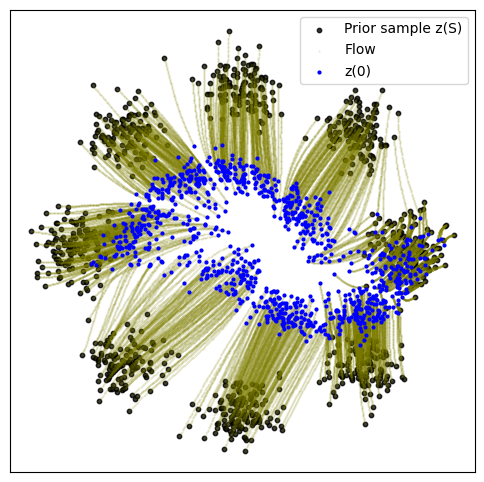

10000: loss 0.155 time 113.37


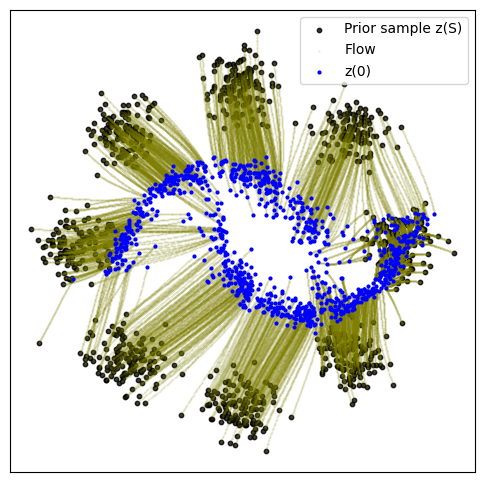

15000: loss 0.127 time 112.65


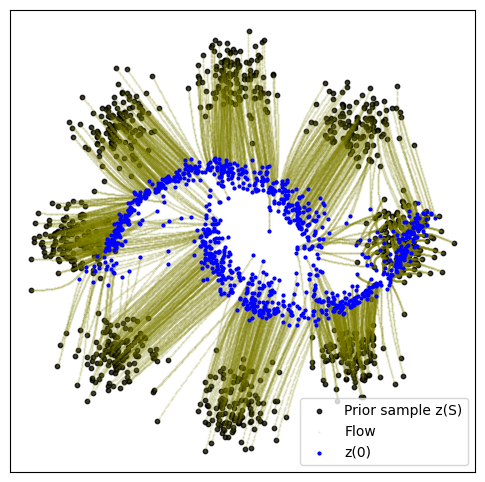

20000: loss 0.247 time 115.25


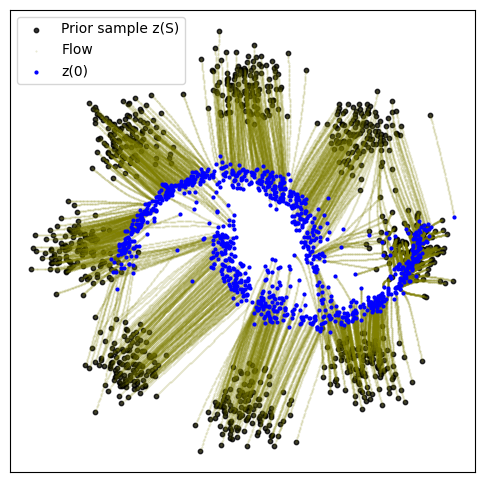

CPU times: total: 53min 22s
Wall time: 7min 34s


In [11]:
%%time
from torchcfm.optimal_transport import OTPlanSampler

ot_sampler = OTPlanSampler(method="exact")
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size).to(device)
    x1 = sample_moons(batch_size).to(device)

    # Draw samples from OT plan
    x0, x1 = ot_sampler.sample_plan(x0, x1)

    t = torch.rand(x0.shape[0]).type_as(x0).to(device)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024).to(device),
                t_span=torch.linspace(0, 1, 100).to(device),
            )
            plot_trajectories(traj.cpu().numpy())